# Naive Bayes model

- Cleaning data
- Naive Bayes model
- Labeling out of sample data
- Making descrptive analysis dataset 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

In [5]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('model_data.pkl')
df.shape

(6943, 2)

In [6]:
df.head()

,cleaned,labels
0,two places id invest money could 3d printing s...,1
1,awesome google driverless cars help blind trav...,1
2,google maps cant keep road construction suppos...,0
3,autonomous cars seem way overhyped given techn...,0
4,saw google selfdriving car i34 painted green blue,2


**Code for encoding**

In [7]:
# df['labels'] = df.sent_numeric.map({'Risky':0, 'Beneficial':1, 'Neutral':2})

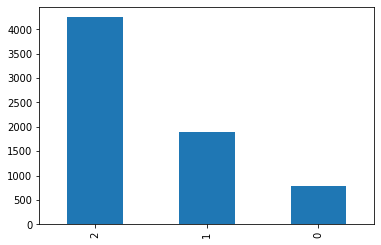

In [8]:
df.labels.value_counts().plot(kind='bar')

In [9]:
df.labels.value_counts()

2    4245
1    1903
0     795
Name: labels, dtype: int64

In [10]:
df.head()

,cleaned,labels
0,two places id invest money could 3d printing s...,1
1,awesome google driverless cars help blind trav...,1
2,google maps cant keep road construction suppos...,0
3,autonomous cars seem way overhyped given techn...,0
4,saw google selfdriving car i34 painted green blue,2


In [11]:
df.isnull().sum()

cleaned    0
labels     0
dtype: int64

# Cleaning

for double check

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [13]:
df['cleaned']=[text_prepare(x) for x in df['cleaned']]

In [14]:
df.cleaned[:5]

0    two places id invest money could 3d printing s...
1    awesome google driverless cars help blind trav...
2    google maps cant keep road construction suppos...
3    autonomous cars seem way overhyped given techn...
4    saw google selfdriving car i34 painted green blue
Name: cleaned, dtype: object

### most common words

In [15]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('tco', 3702),
 ('car', 3600),
 ('cars', 3217),
 ('google', 2582),
 ('selfdriving', 2543),
 ('driverless', 1945),
 ('driving', 1712),
 ('self', 1462),
 ('googles', 620),
 ('autonomous', 385)]

### Splitting data
Split X and y into training and testing sets

In [16]:
X=df['cleaned']
y=df['labels']

In [17]:
X.head()

0    two places id invest money could 3d printing s...
1    awesome google driverless cars help blind trav...
2    google maps cant keep road construction suppos...
3    autonomous cars seem way overhyped given techn...
4    saw google selfdriving car i34 painted green blue
Name: cleaned, dtype: object

In [18]:
y[:5]

0    1
1    1
2    0
3    0
4    2
Name: labels, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5207,)
(1736,)
(5207,)
(1736,)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Only Transform the test sets 
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
    
    
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)

In [21]:
# convert to dense array
X_train_tfidf=X_train_tfidf.toarray()

In [22]:
type(X_train_tfidf)

numpy.ndarray

In [23]:
X_test_tfidf=X_test_tfidf.toarray()

In [24]:
y_train[:5]

1779    2
6239    2
4434    2
4023    1
2945    2
Name: labels, dtype: int64

# Model

In [25]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tfidf,y_train)
predmnb = mnb.predict(X_test_tfidf)

In [26]:
predmnb

array([2, 2, 2, ..., 2, 2, 1])

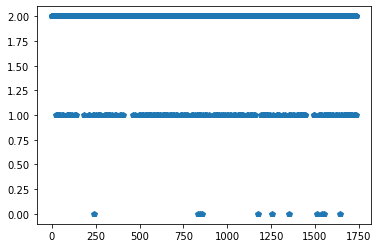

In [27]:
import matplotlib.pyplot as plt
plt.plot(predmnb, "p")

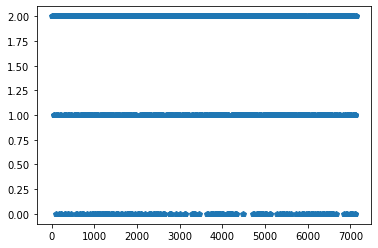

In [28]:
plt.plot(y_test, "p")

# Making the confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predmnb)
cm

array([[   7,   32,  168],
       [   1,  152,  312],
       [   3,   38, 1023]])

### Checking accuracy score

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predmnb)

0.6808755760368663

In [31]:
from sklearn.metrics import classification_report
print (classification_report(y_test, predmnb))

              precision    recall  f1-score   support

           0       0.64      0.03      0.06       207
           1       0.68      0.33      0.44       465
           2       0.68      0.96      0.80      1064

    accuracy                           0.68      1736
   macro avg       0.67      0.44      0.43      1736
weighted avg       0.68      0.68      0.61      1736



# 4)- Label Out of sample data

In [32]:
df = pd.read_csv('tweets.csv', delimiter='\t', header=None,names=['TWEET ID','TIMESTAMP','UTC DATE','USER ID','SCREEN NAME','NAME','Q','TEXT'])
df.shape

(455728, 8)

In [33]:
df.head()

,TWEET ID,TIMESTAMP,UTC DATE,USER ID,SCREEN NAME,NAME,Q,TEXT
0,TWEET ID,TIMESTAMP,UTC DATE,USER ID,SCREEN NAME,NAME,Q,TEXT
1,1024432968759214081,1533078827,2018-07-31 23:13:47,449700739,JamesCageWhite,jameswhite,Q3,"Another reason I failed in love is I'm poor,I ..."
2,1024437049666031616,1533079800,2018-07-31 23:30:00,16665516,therealautoblog,Autoblog,Q3,2019 Mercedes-Benz C 300 and AMG C 43 First Dr...
3,1024427674301865985,1533077565,2018-07-31 22:52:45,505065987,Outridge__84,Outridge,Q3,"Happy birthday to the Audi chasing maniac, hop..."
4,1024430109552508929,1533078145,2018-07-31 23:02:25,14785774,madkins1868,madkins1868,Q3,Come see Mercedes Benz stadium in Atlanta...


In [34]:
out_of_sample=df[['TEXT']]
out_of_sample.shape

(455728, 1)

In [35]:
out_of_sample.head()

,TEXT
0,TEXT
1,"Another reason I failed in love is I'm poor,I ..."
2,2019 Mercedes-Benz C 300 and AMG C 43 First Dr...
3,"Happy birthday to the Audi chasing maniac, hop..."
4,Come see Mercedes Benz stadium in Atlanta...


In [36]:
# Quick cleanup

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [37]:
out_of_sample['TEXT']=[text_prepare(x) for x in out_of_sample['TEXT']]

In [38]:
outofsample=out_of_sample['TEXT']

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Only Transform the test sets 
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
# instead of x_test, we will write outofsample variable    
    
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, outofsample)

In [40]:
X_test_tfidf[:5]

<5x2189 sparse matrix of type '<class 'numpy.float64'>'
	with 36 stored elements in Compressed Sparse Row format>

In [41]:
X_test_tfidf_arr=X_test_tfidf.toarray()

In [42]:
X_test_tfidf_arr[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
predmnb = mnb.predict(X_test_tfidf_arr)

In [44]:
predmnb.shape

(455728,)

**This is our sample. Let's label for descriptive analysis.**

In [45]:
descript=df[['TEXT']]
descript.shape

(455728, 1)

In [46]:
descript['Sentiments']=predmnb

In [47]:
descript.shape

(455728, 2)

In [48]:
descript.head()

,TEXT,Sentiments
0,TEXT,2
1,"Another reason I failed in love is I'm poor,I ...",1
2,2019 Mercedes-Benz C 300 and AMG C 43 First Dr...,2
3,"Happy birthday to the Audi chasing maniac, hop...",1
4,Come see Mercedes Benz stadium in Atlanta...,2


In [49]:
descript.Sentiments.value_counts()

2    417012
1     38080
0       636
Name: Sentiments, dtype: int64

{'Risky':0, 'Beneficial':1, 'Neutral':2}

In [50]:
descript['sentiment_labels'] = descript.Sentiments.map({0:'Risky', 1:'Beneficial', 2:'Neutral'})

In [51]:
descript.head()

,TEXT,Sentiments,sentiment_labels
0,TEXT,2,Neutral
1,"Another reason I failed in love is I'm poor,I ...",1,Beneficial
2,2019 Mercedes-Benz C 300 and AMG C 43 First Dr...,2,Neutral
3,"Happy birthday to the Audi chasing maniac, hop...",1,Beneficial
4,Come see Mercedes Benz stadium in Atlanta...,2,Neutral


In [52]:
descript.sentiment_labels.value_counts()

Neutral       417012
Beneficial     38080
Risky            636
Name: sentiment_labels, dtype: int64

### save work

In [53]:
descript.to_pickle('descript.pkl')
descript.to_csv('descript.csv',index=False)

# END of Notebook